In [1]:
from src.pipeline import build_pipeline

departure = 'LEMD'
destinations = ['LEBL']

flights_path = 'data/flights'
flights_points_path = 'data/flight_points'

data_pipeline = build_pipeline(flights_path = flights_path, 
                               flights_points_path = flights_points_path, 
                               departure = departure, 
                               destinations = destinations)

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

(600.0, 800.0, 0.0, 0.01)

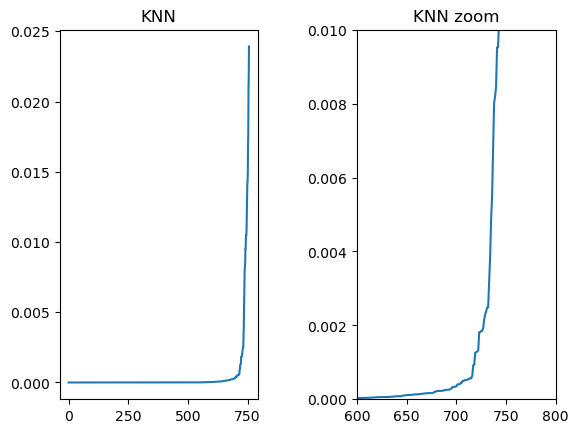

In [2]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([600, 800, 0, 0.01])

In [38]:
import pandas as pd
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(sspd_distances, params = {
  "eps": np.arange(0.001, 0.015, 0.001),
  "min_samples": np.arange(3, 16)
})

print(pd.DataFrame(search["results_"]).head(20))

                               params  clusters  outliers     noise     score
0    {'eps': 0.007, 'min_samples': 4}         4        24  3.170410  0.904352
1    {'eps': 0.007, 'min_samples': 5}         4        24  3.170410  0.904352
2    {'eps': 0.007, 'min_samples': 6}         4        24  3.170410  0.904352
3    {'eps': 0.007, 'min_samples': 7}         4        24  3.170410  0.904352
4    {'eps': 0.007, 'min_samples': 8}         4        28  3.698811  0.897972
5    {'eps': 0.007, 'min_samples': 9}         4        28  3.698811  0.897972
6   {'eps': 0.007, 'min_samples': 10}         4        28  3.698811  0.897972
7   {'eps': 0.007, 'min_samples': 11}         4        28  3.698811  0.897972
8   {'eps': 0.007, 'min_samples': 12}         4        30  3.963012  0.894510
9   {'eps': 0.007, 'min_samples': 13}         4        30  3.963012  0.894510
10  {'eps': 0.007, 'min_samples': 14}         4        30  3.963012  0.894510
11  {'eps': 0.007, 'min_samples': 15}         4        30  3.963

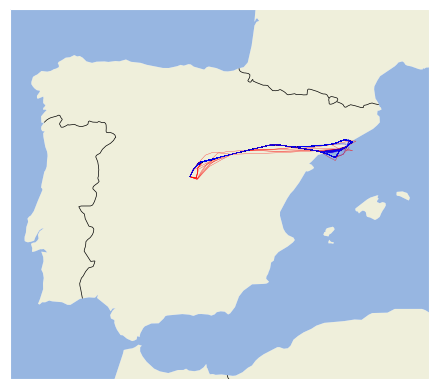

In [39]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

# Run the grid search
params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(sspd_distances)
labels = clusterer.labels_

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/single-trajectory/outliers_sspd_dbscan.png')

### HDBSCAN

In [37]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
})

print(pd.DataFrame(search["results_"]).head(20))

                                          params  clusters  outliers   
0    {'min_samples': 1, 'min_cluster_size': 100}         4        18  \
1    {'min_samples': 2, 'min_cluster_size': 100}         4        18   
2    {'min_samples': 3, 'min_cluster_size': 100}         4        18   
3    {'min_samples': 4, 'min_cluster_size': 100}         4        18   
4    {'min_samples': 5, 'min_cluster_size': 100}         4        18   
5    {'min_samples': 6, 'min_cluster_size': 100}         4        18   
6    {'min_samples': 7, 'min_cluster_size': 100}         4        18   
7    {'min_samples': 8, 'min_cluster_size': 100}         4        18   
8    {'min_samples': 9, 'min_cluster_size': 100}         4        18   
9   {'min_samples': 10, 'min_cluster_size': 100}         4        18   
10  {'min_samples': 11, 'min_cluster_size': 100}         4        18   
11  {'min_samples': 12, 'min_cluster_size': 100}         4        18   
12  {'min_samples': 13, 'min_cluster_size': 100}         4      

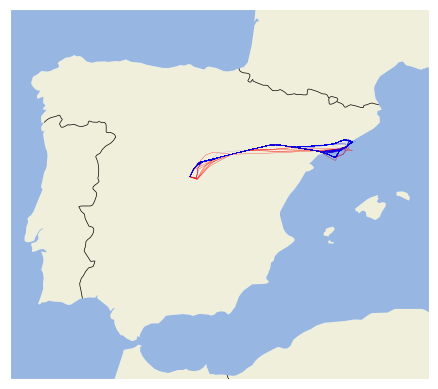

In [23]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/single-trajectory/outliers_sspd_hdbscan.png')

## ERP Distances

### DBSCAN

(600.0, 800.0, 0.0, 100000.0)

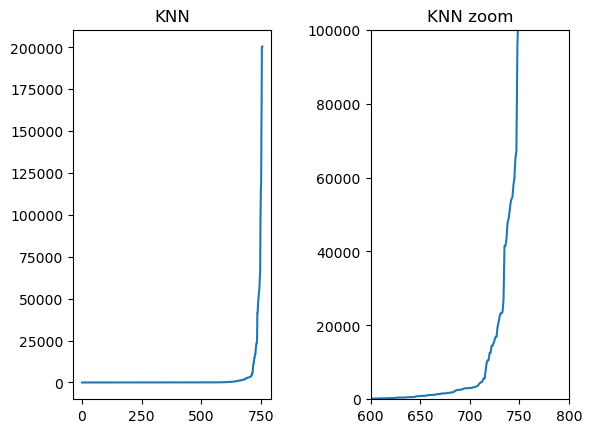

In [24]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([600, 800, 0, 100000])

In [32]:
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(erp_distances, params = {
  "eps": np.arange(10000, 100000, 10000),
  "min_samples": np.arange(1, 5)
})

print(pd.DataFrame(search["results_"]).head(20))

                              params  clusters  outliers     noise     score
0   {'eps': 40000, 'min_samples': 3}         7        24  3.170410  0.910377
1   {'eps': 30000, 'min_samples': 3}         7        26  3.434610  0.907553
2   {'eps': 40000, 'min_samples': 4}         6        27  3.566711  0.905310
3   {'eps': 70000, 'min_samples': 4}         6        12  1.585205  0.904937
4   {'eps': 80000, 'min_samples': 4}         6        12  1.585205  0.904937
5   {'eps': 90000, 'min_samples': 4}         6        12  1.585205  0.904937
6   {'eps': 60000, 'min_samples': 4}         6        14  1.849406  0.903676
7   {'eps': 30000, 'min_samples': 4}         5        32  4.227213  0.900961
8   {'eps': 50000, 'min_samples': 4}         5        24  3.170410  0.897874
9   {'eps': 70000, 'min_samples': 2}         7         9  1.188904  0.894544
10  {'eps': 70000, 'min_samples': 3}         7         9  1.188904  0.894544
11  {'eps': 80000, 'min_samples': 2}         7         9  1.188904  0.894544

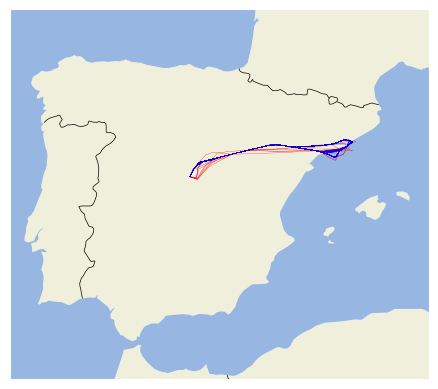

In [33]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/single-trajectory/outliers_erp_dbscan.png')

### HDBSCAN

In [34]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
})

print(pd.DataFrame(search["results_"]).head(20))


                                          params  clusters  outliers   
0    {'min_samples': 1, 'min_cluster_size': 100}         4        18  \
1    {'min_samples': 2, 'min_cluster_size': 100}         4        18   
2    {'min_samples': 3, 'min_cluster_size': 100}         4        18   
3    {'min_samples': 4, 'min_cluster_size': 100}         4        18   
4    {'min_samples': 5, 'min_cluster_size': 100}         4        18   
5    {'min_samples': 6, 'min_cluster_size': 100}         4        18   
6    {'min_samples': 7, 'min_cluster_size': 100}         4        18   
7    {'min_samples': 8, 'min_cluster_size': 100}         4        18   
8    {'min_samples': 9, 'min_cluster_size': 100}         4        18   
9   {'min_samples': 10, 'min_cluster_size': 100}         4        18   
10  {'min_samples': 11, 'min_cluster_size': 100}         4        18   
11  {'min_samples': 12, 'min_cluster_size': 100}         4        18   
12  {'min_samples': 13, 'min_cluster_size': 100}         4      

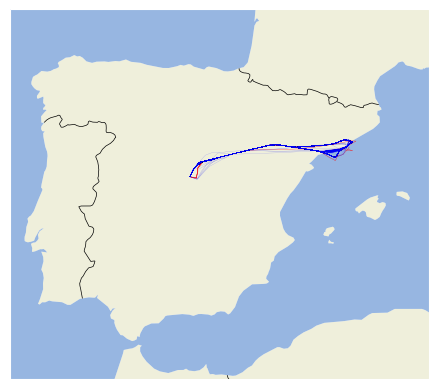

In [36]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/single-trajectory/outliers_erp_hdbscan.png')